# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=df625b55a89ab14072929c10caabfefbdae3e43292757ff395be72a6d9a001f7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=90b5102bd7d1bd2f367a70681dc39aafd556ccaba065fd93cc0034dfdfc4172d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

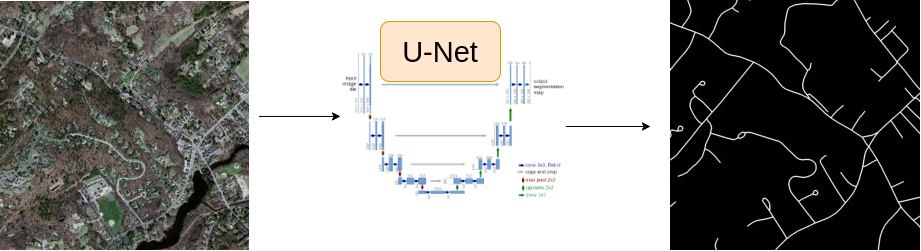

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png
...,...,...
194,images/18178735_15.png,masks/18178735_15.png
195,images/24178480_15.png,masks/24178480_15.png
196,images/24629305_15.png,masks/24629305_15.png
197,images/23728495_15.png,masks/23728495_15.png


In [7]:
idx = 15
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255

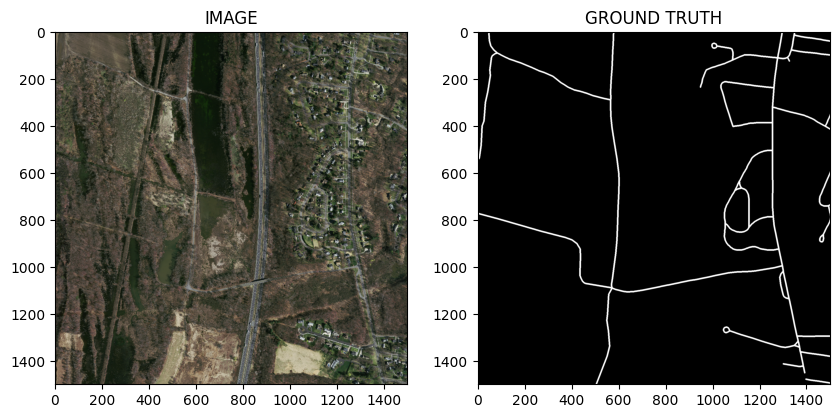

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [9]:
train_df,valid_df = train_test_split(df, test_size = 0.20,random_state=42)

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask  = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of vaidset : {len(validset)}')

Size of trainset : 159
Size of vaidset : 40


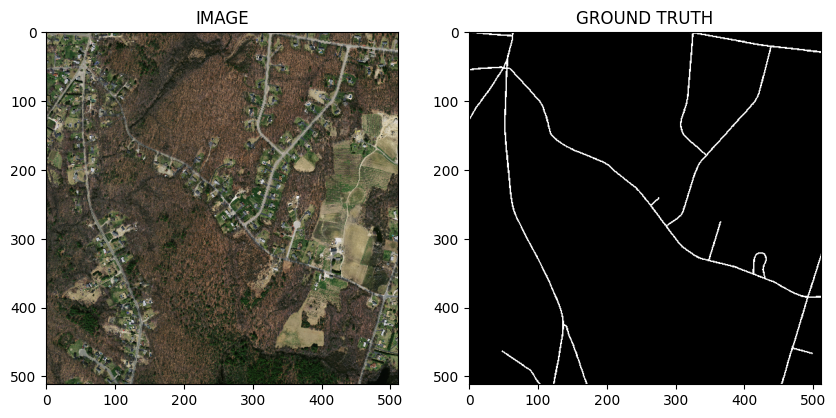

In [16]:

idx = 69

image,mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [20]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


In [23]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break;

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [24]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [26]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [29]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [31]:
def train_fn(dataloader, model, optimizer):

  model.train()

  total_loss = 0.0

  for images, masks in tqdm(dataloader):
     images = images.to(DEVICE)
     masks = masks.to(DEVICE)

     optimizer.zero_grad()
     logits, loss = model(images, masks)
     loss.backward()
     optimizer.step()

     total_loss += loss.item()

  return total_loss/ len(dataloader)

In [33]:
def eval_fn(dataloader, model):

  model.eval()

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss/ len(dataloader)

# Task 8 : Train Model

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [35]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model ,optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 1.0659482210874558 Valid Loss : 0.9369793176651001


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.7541057407855988 Valid Loss : 0.8261605620384216


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.6966109573841095 Valid Loss : 0.7948090195655823


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.6809414118528366 Valid Loss : 0.7354789733886719


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


SAVED-MODEL
Epoch : 5 Train Loss : 0.6677860826253891 Valid Loss : 0.68072669506073


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 6 Train Loss : 0.6324448585510254 Valid Loss : 0.7259111046791077


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch : 7 Train Loss : 0.6320208638906479 Valid Loss : 0.6777657866477966


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 8 Train Loss : 0.6335721492767334 Valid Loss : 0.7095796227455139


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch : 9 Train Loss : 0.6167684733867645 Valid Loss : 0.6783315658569335


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


SAVED-MODEL
Epoch : 10 Train Loss : 0.6122745469212532 Valid Loss : 0.6751067161560058


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch : 11 Train Loss : 0.6010078489780426 Valid Loss : 0.7097626566886902


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 12 Train Loss : 0.6071897387504578 Valid Loss : 0.681864321231842


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


SAVED-MODEL
Epoch : 13 Train Loss : 0.5923977702856064 Valid Loss : 0.650433611869812


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Epoch : 14 Train Loss : 0.5950743496418 Valid Loss : 0.7179826498031616


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


SAVED-MODEL
Epoch : 15 Train Loss : 0.603497388958931 Valid Loss : 0.6416705012321472


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 16 Train Loss : 0.5827690452337265 Valid Loss : 0.6474514484405518


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


SAVED-MODEL
Epoch : 17 Train Loss : 0.58310437053442 Valid Loss : 0.6378039598464966


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch : 18 Train Loss : 0.5714640915393829 Valid Loss : 0.6552061319351197


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


SAVED-MODEL
Epoch : 19 Train Loss : 0.5723985612392426 Valid Loss : 0.6360104799270629


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 20 Train Loss : 0.60341217815876 Valid Loss : 0.6904735684394836


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


SAVED-MODEL
Epoch : 21 Train Loss : 0.5781309142708778 Valid Loss : 0.6227929353713989


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 22 Train Loss : 0.570459458231926 Valid Loss : 0.6379895091056824


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 23 Train Loss : 0.5651648804545403 Valid Loss : 0.6361588478088379


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 24 Train Loss : 0.5695011496543885 Valid Loss : 0.6625194311141968


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

SAVED-MODEL
Epoch : 25 Train Loss : 0.5671523436903954 Valid Loss : 0.619580614566803


# Task 9 : Inference

In [47]:
idx = 17

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

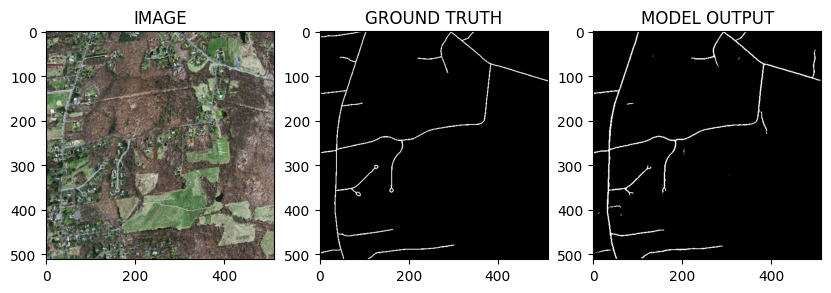

In [48]:
helper.show_image(image,mask, pred_mask.detach().cpu().squeeze(0))